In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create model


![](https://drive.google.com/uc?id=14vdsXnB52Llqjuyhf4bZ2g5zMUVXZvq0)<br>
Four stages, seperated by horizontal lines:<br>
![](https://drive.google.com/uc?id=1HwutGjIQ4AkJubH1osbJm-R4YWcA1sKO)<br>
t: expansion factor of the bottleneck block<br>
c: number of output channels<br>
n: number of times block is repeated<br>
s: stride parameter which is applied to first sequence of the repeating block<br>
f: non-linear function<br><br>
bottleneck architecture:<br>
![](https://drive.google.com/uc?id=1YJZ6HwmolVmCxyoaHZ3y6ITfYN6AUlBg)<br>
Feature fusion:<br>
![](https://drive.google.com/uc?id=19L6uM5S3cTt-2jlTG48Nf6WjJKA3lVUK)<br>

<br>
* Batch normalization [12] is used before every non-linear function. Dropout is used only on the last layer, just before the softmax layer.<br>
Then we directly upsample the low-dimension feature maps to get the same size
feature as the original feature map via bilinear interpolation<br><br>
* For Feature Fusion Module (FFM), I follow the steps described in the "Cascade Feature Fusion" section in the ICNet paper.





In [ ]:
import math
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization,\
Dropout, MaxPooling2D, concatenate, ReLU, SeparableConv2D, DepthwiseConv2D,\
AveragePooling2D, Concatenate

In [ ]:
IMG_HEIGHT = 320 # 1024
IMG_WIDTH = 480  # 2048
IMG_CHANNELS = 3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

## Learning to Down-sample 
# Conv2D
learning_to_down_sample = Conv2D(32, 3, strides=(2, 2), padding='same')(s)
learning_to_down_sample = BatchNormalization()(learning_to_down_sample)
learning_to_down_sample = ReLU()(learning_to_down_sample)
# DSConv
learning_to_down_sample = SeparableConv2D(48, 3, strides=(2, 2), padding='same')(learning_to_down_sample)
learning_to_down_sample = BatchNormalization()(learning_to_down_sample)
learning_to_down_sample = ReLU()(learning_to_down_sample)
# DSConv
learning_to_down_sample = SeparableConv2D(64, 3, strides=(2, 2), padding='same')(learning_to_down_sample)
learning_to_down_sample = BatchNormalization()(learning_to_down_sample)
learning_to_down_sample = ReLU()(learning_to_down_sample)

bottleneck = learning_to_down_sample
pre_c = learning_to_down_sample.shape[3]

# Global Feature Extrator
for i, c in enumerate([64, 96, 128]):
  for k in range(3):
    stride = 2 if (k == 0 and c != 128) else 1
    # Conv2D 1/1, f
    bottleneck = Conv2D(pre_c * 6, 1, strides=(1, 1), padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = ReLU()(bottleneck)
    # DWConv 3/s, f
    bottleneck = DepthwiseConv2D(3, strides=(stride, stride), padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = ReLU()(bottleneck)
    #Conv2D 1/1, -
    bottleneck = Conv2D(c, 1, strides=(1, 1), padding='same')(bottleneck)
    pre_c = bottleneck.shape[3]

print(f'bottleneck: {bottleneck.shape}')

# Pyramid Pooling
bins = [1, 2, 3, 6]
pre_h = bottleneck.shape[1]
pre_w = bottleneck.shape[2]
layers = [bottleneck]
for b in bins:
  kernel_h = math.ceil(pre_h/b)
  kernel_w = math.ceil(pre_w/b)
  pooling = AveragePooling2D((kernel_h, kernel_w), padding='same')(bottleneck)
  pooling = Conv2D(round(pre_c/len(bins)), 1, padding='same')(pooling)
  pooling = Lambda(lambda x: tf.image.resize(x, (pre_h,pre_w)))(pooling)
  layers.append(pooling)
  print(f'pyramid pooling: {pooling.shape}')

pooling = Concatenate()(layers)

# Feature Fusion
high_res = Conv2D(128, 1, padding='same')(learning_to_down_sample)

upsample_h = high_res.shape[1]//pooling.shape[1]
upsample_w = high_res.shape[2]//pooling.shape[2]

low_res = Lambda(lambda x: tf.image.resize(x, (high_res.shape[1],high_res.shape[2])))(pooling)
low_res = DepthwiseConv2D(3, padding='same', dilation_rate=(upsample_h, upsample_w))(low_res)
low_res = BatchNormalization()(low_res)
low_res = ReLU()(low_res)
low_res = Conv2D(128, 1, padding='same')(low_res)

fusion = tf.keras.layers.add([high_res, low_res])
fusion = BatchNormalization()(fusion)
fusion = ReLU()(fusion)
print(f'Fusion output: {fusion.shape}')

# Classifier
clf = SeparableConv2D(128, 3, padding='same')(fusion)
clf = SeparableConv2D(128, 3, padding='same')(clf)
#clf = Conv2D(19, 1)(clf) # for 19-class classification
clf = Conv2D(1, 1, activation='sigmoid')(clf)
clf = Dropout(0.2)(clf)
clf = Lambda(lambda x: tf.image.resize(x, (IMG_HEIGHT,IMG_WIDTH)))(clf)
#clf = tf.keras.activations.softmax(clf)
print(f'Output: {clf.shape}')



bottleneck: (None, 10, 15, 128)
pyramid pooling: (None, 10, 15, 32)
pyramid pooling: (None, 10, 15, 32)
pyramid pooling: (None, 10, 15, 32)
pyramid pooling: (None, 10, 15, 32)
Fusion output: (None, 40, 60, 128)
Output: (None, 320, 480, 1)


# Prepare training data

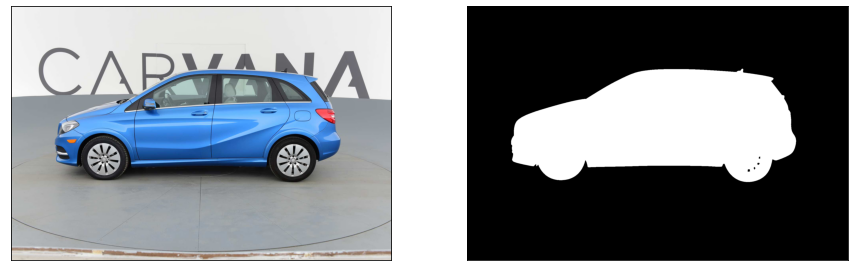

In [ ]:
import os
from matplotlib import pyplot as plt

X_train_path = '/content/drive/MyDrive/Colab Notebooks/Carvana_UNet/train'
y_train_path = '/content/drive/MyDrive/Colab Notebooks/Carvana_UNet/train_masks'
y_test_path = '/content/drive/MyDrive/Colab Notebooks/Carvana_UNet/test_12'

X_dir,_,X_files = next(os.walk(X_train_path))
y_dir,_,y_files = next(os.walk(y_train_path))

TRAIN_SIZE = 1000

X_train_files = [os.path.join(X_dir, f) for f in X_files][:TRAIN_SIZE]
y_train_files = [os.path.join(y_dir, os.path.splitext(f)[0] + '_mask.gif') for f in X_files][:TRAIN_SIZE]

plt.figure(figsize=(15, 10))
for i, path in enumerate([X_train_files[0], y_train_files[0]]):
  plt.subplot(1, 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img = plt.imread(path)
  plt.imshow(img)
plt.show()

# Load training data into memory

In [ ]:
import numpy as np

X_train = np.zeros((len(X_train_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),\
                   dtype=np.uint8)
Y_train = np.zeros((len(y_train_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:
from PIL import Image
from tqdm import tqdm


for i, (img_path, mask_path) in tqdm(enumerate(zip(X_train_files, y_train_files))\
                                     ,total=len(X_train_files), position=0):
  img = Image.open(img_path)
  img = img.resize((IMG_WIDTH, IMG_HEIGHT))
  img_arr = np.asarray(img)

  X_train[i] = img_arr

  mask = Image.open(mask_path)
  mask = mask.resize((IMG_WIDTH, IMG_HEIGHT))
  mask_arr = np.asarray(mask)
  mask_arr = np.expand_dims(mask_arr, axis=2)  # reshape to (h, w, 1)

  Y_train[i] = mask_arr

100%|██████████| 1000/1000 [15:34<00:00,  1.07it/s]


In [ ]:
from tensorflow.keras.models import Model

model = Model(inputs=[inputs], outputs=[clf])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 480, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 320, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 240, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 240, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

# Make initial prediction

1/1 [==============================] - 7s 7s/step


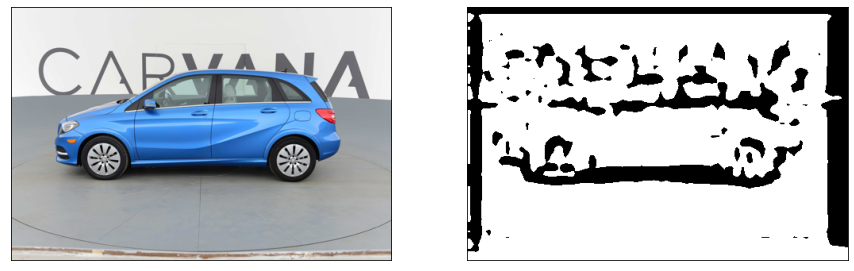

In [ ]:
pred = model.predict(X_train[:1], verbose=1)
pred_mask = np.where(pred >= 0.5, 255, 0)
pred_mask = np.repeat(pred_mask, 3, axis=3)

fig = plt.figure(figsize=(15, 10))
for i, img in enumerate([X_train, pred_mask]):
  plt.subplot(1, 2, i+1)
  plt.imshow(img[0])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
plt.show()

# Start training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ROOT = '/content/drive/MyDrive/Colab Notebooks/Fast-SCNN'
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint(os.path.join(ROOT, 'fast-scnn.h5'), verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/100
57/57 [==============================] - 12s 149ms/step - loss: 0.4468 - accuracy: 0.7327 - val_loss: 0.7780 - val_accuracy: 0.7781

Epoch 00001: val_loss improved from inf to 0.77798, saving model to /content/drive/MyDrive/Colab Notebooks/Fast-SCNN/fast-scnn.h5
Epoch 2/100
57/57 [==============================] - 8s 135ms/step - loss: 0.1291 - accuracy: 0.9439 - val_loss: 1.3498 - val_accuracy: 0.7781

Epoch 00002: val_loss did not improve from 0.77798
Epoch 3/100
57/57 [==============================] - 8s 135ms/step - loss: 0.1076 - accuracy: 0.9541 - val_loss: 1.7518 - val_accuracy: 0.7781

Epoch 00003: val_loss did not improve from 0.77798
Epoch 4/100
57/57 [==============================] - 8s 135ms/step - loss: 0.1106 - accuracy: 0.9532 - val_loss: 2.7812 - val_accuracy: 0.7781

Epoch 00004: val_loss did not improve from 0.77798
Epoch 5/100
57/57 [==============================] - 8s 134ms/step - loss: 0.0958 - accuracy: 0.9598 - val_loss: 3.4195 - val_accuracy: 0.77

# Predict training set

1/1 [==============================] - 0s 221ms/step


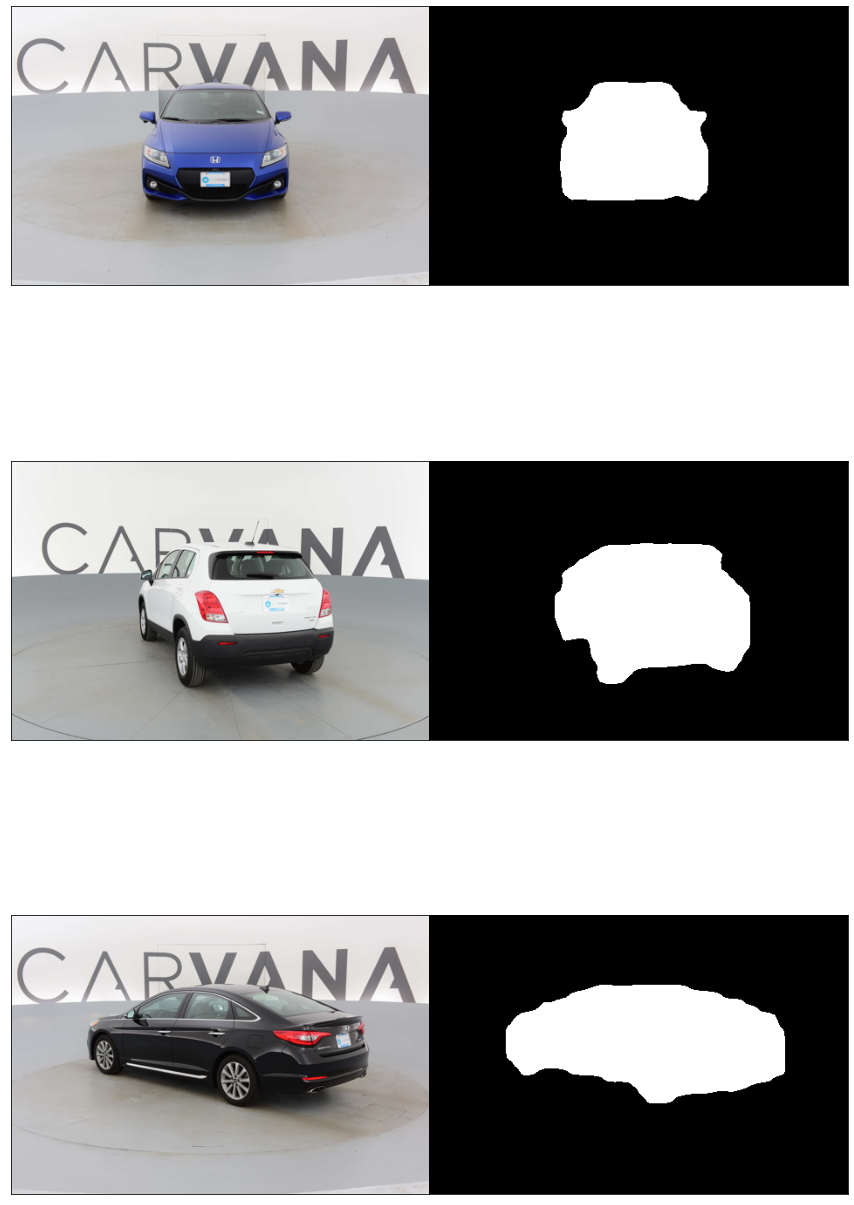

In [ ]:
NUM_SAMPLES = 3
inds = np.random.choice(X_train.shape[0], NUM_SAMPLES, replace=False)
X_test = X_train[inds]
pred = model.predict(X_test, verbose=1)

pred_mask = np.where(pred >= 0.5, 255, 0)
pred_mask = np.repeat(pred_mask, 3, axis=3)

fig = plt.figure(figsize=(15, 25))
fig.subplots_adjust(wspace=0, hspace=0.01)
for i, (img, mask) in enumerate(zip(X_test, pred_mask)):
  plt.subplot(NUM_SAMPLES, 2, 2*i+1)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.subplot(NUM_SAMPLES, 2, 2*i+2)
  plt.imshow(mask)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
plt.show()

# Predict test dataset